# CSI proccessing for Uganda data

### import modules

In [2]:
%matplotlib widget
from matplotlib import pyplot as plt

from pathlib import Path
import suspect
import numpy as np
import datetime 
import pandas as pd
import subprocess
import shutil
import os
from tqdm import tqdm 
import pydicom as dcm
import struct as st
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from fpdf import FPDF
from pdf2image import convert_from_path

import warnings 
import pickle
from pprint import pprint



### Definitions

In [60]:
class SpecObject(object):
    
    NumSpecObjects = 0  #To keep track of how many spec objects there are
    spectypes = {0 : "Not a spectroscopy dataset", \
                 1 : "classic spectroscopy dataset", \
                 2 : "Enhanced spectroscopy dataset", \
                 3 : "Siemens IMA file", \
                 4 : "RDA file"}

    def __init__(self, filename):
        
        self.filename = filename  
        SpecObject.NumSpecObjects += 1        
        # print(filename)
        try:
            ds = dcm.read_file(str(self.filename))
#             self.ds = ds
        except:
            ds = []
            SpecObject.NumSpecObjects -= 1
        
        if ds:
            try:
                self.csi_mat = [ds[0x2005, 0x1371][0][0x2005, 0x1376].value, ds[0x2005, 0x1371][0][0x2005, 0x1377].value]
                #pat
                # print(f'{self.filename=}')

                # print(f'{ds[0x2005,0x1270].value=}')
                
                #endpat
            except:
                self.csi_mat = []
                

        



        if [0x2005,0x1270] in ds:
            self.isspec = 1
            self.Frames = 1
            self.Datapoints = ds[0x2005,0x1315].value
            # print(type(self.Datapoints))
            self.SpectralWidth = 1.0/ds[0x2005,0x1338].value
            self.Frequency = ds[0x2001,0x1083].value
            self.FieldStrength = ds.MagneticFieldStrength
            self.PatName = ds.PatientName
            self.PatID = ds.PatientID
            self.StudyDate = ds.StudyDate
            self.StudyTime = ds.StudyTime
            self.SeriesDate = ds.SeriesDate
            self.SeriesTime = ds.SeriesTime
            self.ManufacturerModelName = ds.ManufacturerModelName
            self.ProtocolName = ds.ProtocolName
            self.TR = ds.RepetitionTime
            self.TE = ds[0x2001,0x1025].value
            self.DwellTime = ds[0x2005,0x1338].value
            self.NAverages = 1
            self.SeriesNumber = ds.SeriesNumber
            self.FlipAngle = ds.FlipAngle
            # self.SpecData = st.unpack_from('ff'*self.Datapoints, ds[0x2005,0x1270].value, 0)
            self.SpecData = ds[0x2005,0x1270].value
            
                
        elif [0x5600,0x0020] in ds:
            self.isspec = 2
            self.PatName = ds.PatientName
            self.StudyDate = ds.StudyDate
            self.StudyTime = ds.StudyTime
            self.SeriesDate = ds.SeriesDate
            self.SeriesTime = ds.SeriesTime
            self.SpecData = ds[0x5600,0x0020].value
            self.Datapoints = ds.DataPointColumns
            self.SpectralWidth = ds.SpectralWidth
            self.Frequency = ds.TransmitterFrequency
            self.FieldStrength = ds.MagneticFieldStrength
            self.PatID = ds.PatientID
            self.AcquisitionDateTime = ds.AcquisitionDateTime
            self.ManufacturerModelName = ds.ManufacturerModelName
            self.ProtocolName = ds.ProtocolName            
            self.Frames = ds.NumberOfFrames
            self.TR = ds[0x5200,0x9230][0][0x0018,0x9112][0][0x0018,0x0080].value
            # TR is contained within a sequence
            
            
        elif [0x7fe1, 0x1010] in ds:
            self.isspec = 3
            self.Frames = 1
            header = ds[0x0029,0x1120].value
            offset = header.find('Para.lVectorSize                    = ')
            self.Datapoints = int(header[offset+38:offset+42])*2
            
            offset = header.find('Frequency      =')
            self.TransmitterFrequency = float(header[offset+17:offset+25])
            offset = header.find('TR[')
            tempbuffer = header[offset:offset+80]
            beginoffset = tempbuffer.find('=')
            endoffset = tempbuffer.find('\n')
            self.TR = int(header[offset+beginoffset+2:offset+endoffset])/1000
            
            offset = header.find('TE[')
            tempbuffer = header[offset:offset+80]
            beginoffset = tempbuffer.find('=')
            endoffset = tempbuffer.find('\n')
            self.TE = int(header[offset+beginoffset+2:offset+endoffset])/1000
            
            self.SpecData = st.unpack_from('ff'*self.Datapoints, ds[0x7fe1, 0x1010].value, 0)
            # print(self.SpecData)
            
        elif str(self.filename).lower().endswith('.rda'):
            self.isspec = 4         # RDA file
            self.Frames = 1
            f = open(self.filename, 'rb')
            finished = 0
            while finished == 0:
                 header_line = f.readline()   
                 if header_line.startswith('>>> End of header <<<'):
                     finished = 1
                 if header_line.startswith('PatientName'):
                     ind1 = header_line.index(':') + 1
                     ind2 = header_line.index('\n')
                     self.PatName = header_line[ind1:ind2]
                 if header_line.startswith('PatientID'):
                     ind1 = header_line.index(':') + 1
                     ind2 = header_line.index('\n')
                     self.PatID = header_line[ind1:ind2]
                 if header_line.startswith('StudyDate'):
                     ind1 = header_line.index(':') + 1
                     ind2 = header_line.index('\n')
                     self.StudyDate = header_line[ind1:ind2]
                 if header_line.startswith('StudyTime'):
                     ind1 = header_line.index(':') + 1
                     ind2 = header_line.index('\n')
                     self.StudyTime = header_line[ind1:ind2]
                 if header_line.startswith('ProtocolName'):
                     ind1 = header_line.index(':') + 1
                     ind2 = header_line.index('\n')
                     self.ProtocolName = header_line[ind1:ind2]
                 if header_line.startswith('SeriesNumber'):
                     ind1 = header_line.index(':') + 1
                     ind2 = header_line.index('\n')
                     self.SeriesNumber = header_line[ind1:ind2]
                 if header_line.startswith('TE'):
                     ind1 = header_line.index(':') + 1
                     ind2 = header_line.index('\n')
                     self.TE = int(float(header_line[ind1:ind2]))
                 if header_line.startswith('TR'):
                     ind1 = header_line.index(':') + 1
                     ind2 = header_line.index('\n')
                     self.TR = int(float(header_line[ind1:ind2]))
                 if header_line.startswith('DwellTime'):
                     ind1 = header_line.index(':') + 1
                     ind2 = header_line.index('\n')
                     self.DwellTime = float(header_line[ind1:ind2]) * 1e-6
                 if header_line.startswith('NumberOfAverages'):
                     ind1 = header_line.index(':') + 1
                     ind2 = header_line.index('\n')
                     self.NAverages = int(float(header_line[ind1:ind2]))
                 if header_line.startswith('MRFrequency'):
                     ind1 = header_line.index(':') + 1
                     ind2 = header_line.index('\n')
                     self.Frequency = header_line[ind1:ind2]
                 if header_line.startswith('VectorSize'):
                     ind1 = header_line.index(':') + 1
                     ind2 = header_line.index('\n')
                     self.Datapoints = int(float(header_line[ind1:ind2]))   
            
            sizedata = self.Datapoints * 2 * 8  #size of block of data to be read (8 because data is size double)
            f.seek(-sizedata,2)         # Find start fo data by searching backwards from end of file          
            rawdata = f.read()      #read raw data into temp variable for unpacking
            self.SpecData = st.unpack_from('<' + 'dd'*(self.Datapoints), rawdata, 0)  
            self.endpos = f.tell()     
            
            f.close()

        else:
            self.isspec = 0
            self.SpecData = []
        
        if self.isspec != 0:
            self.complex_data()
   
        # print(self.isspec)


    
    def complex_data(self):
        self.Kspace = []
        self.Spectrum = []
        dummyKspace = np.zeros(shape = [self.Datapoints], dtype = complex)
        for b in range(0, self.Frames):
            counter = 0
            for a in range(0, self.Datapoints*2, 2):
                dummyKspace[counter] = np.conj(complex(self.SpecData[(b*self.Datapoints*2) + a], self.SpecData[(b*self.Datapoints*2)+a+1]))
#                 dummyKspace[counter] = complex(self.SpecData[(b*self.Datapoints*2) + a], self.SpecData[(b*self.Datapoints*2)+a+1])
                counter  = counter + 1
            self.Kspace.append(dummyKspace)
                            

#             if self.isspec == 4:
#                 dummyspectrum = np.fft.fftshift(np.fft.fft(dummyKspace))
#             else:
#                 dummyspectrum = np.fft.fftshift(np.fft.fft(np.conj(dummyKspace)))
                
#             dummyspectrum = np.fft.fftshift(np.fft.fft(dummyKspace))

#             self.Spectrum.append(dummyspectrum)
            
        if self.Frames != 1:
            self.create_final()
    
    def create_final(self):
        self.FinalKspace = np.zeros(shape = [self.Datapoints], dtype = complex)
        frames = self.Frames/2
        for cnt in range(0, frames):
            self.FinalKspace = self.FinalKspace + self.Kspace[cnt]
#             self.FinalSpectrum = self.FinalSpectrum + self.Spectrum[cnt]
     
    def spectype(self):
        for key,value in self.spectypes.items():
            if key == self.isspec:
                print(value)

    def __repr__(self):
        return f'{self.ProtocolName}_{self.SeriesTime}'
                   
    def auto_phase(self):
        suspect.processing.phase.acme(self)
   


class Serie():

    def __init__(self, sn):
        self.series_number = sn
        self.sp_objects = []
        self.protocol_name = []
        self.Patient_ID = []
        self.TE = []
        self.csi_mat = []
        
    def add_sp(self,sp):
        self.sp_objects.append(sp)
        if not self.protocol_name:
            self.protocol_name = sp.ProtocolName
            self.Patient_ID = sp.PatID
            self.TE = sp.TE
            self.csi_mat = sp.csi_mat

    def __repr__(self):
        return f'{self.protocol_name}: with {len(self.sp_objects)} objects'
    


    
def fit_PRESS(press_data, water_ref):
    sv_press=suspect.MRSData(press_data.Kspace[0], press_data.DwellTime, press_data.Frequency, int(press_data.TE), press_data.TR)
    sv_press_ref=suspect.MRSData(water_ref.Kspace[0], water_ref.DwellTime, water_ref.Frequency, int(water_ref.TE), water_ref.TR)
    out_folder = Path.cwd()/'Tarquin_results'
    out_folder.mkdir(parents=True, exist_ok=True)
    fit_params = {
                'output_pdf': out_folder/'tarquin_SV_PRESS.pdf', 
                }
    if int(press_data.TE) > 280:
        fit_params['basis_csv']= Path.cwd()/'Basis_threonine_no_MM'
    else:
        warnings.warn(f'TE={int(press_data.TE)} ms. Check if this is correct (normally we use a long TE of 288 ms for SV_PRESS).')      
    press_results = suspect.io.tarquin.process(sv_press, sv_press_ref, fit_params)       
    press_results.update(dict(Patient_ID = press_data.PatID))
    press_results.update(dict(TE = press_data.TE))
    return press_results

def get_met_info(met_list, results):
    met_dic = {}
    for met in met_list:
        try:
            con = np.float(results['metabolite_fits'][met]['concentration'])
            sd = con*np.float(results['metabolite_fits'][met]['sd'])/100
            sd = 0 if np.isinf(sd) else sd
            sd = 0 if np.isnan(sd) else sd
        except:
            con = 0.0
            sd = 0
        met_dic.update( {met: {'concentration':con,'sd':sd}} )    
    return met_dic       
    
def Report_SV_PRESS_HI(series):
    ## Fit the data with Tarquin
    for serie in series:
        if len(serie.sp_objects) == 2:
            print(f'Fitting {serie.protocol_name} data...')
            press_data = serie.sp_objects[0]
            water_ref = serie.sp_objects[1]

            
    press_results = fit_PRESS(press_data,water_ref)
    
    
    exported_folder = press_data.filename.parent.parent
    print(exported_folder)
    if exported_folder.stem.lower() == 'dicom':
        exported_folder = exported_folder.parent
        print(exported_folder)
        
    ID = str(exported_folder.stem)
    if ID.find('_MRS') != -1:
        ID = ID[0:ID.find('_MRS')]
    print(ID)    
        
    
    print(f' - Tarquin fit completed.')        
    # Choose metabolites
    my_metabolites = ['Lac', 'TNAA', 'Cr', 'TCho' ,'Threonine']
    
    
    mets = get_met_info(my_metabolites,press_results)   
    ## Hipoxia-Ischemia metabolites
    Lac = mets['Lac']['concentration']
    print(f'Lac={Lac}')
    Lace = mets['Lac']['sd']
    print(f'Lace={Lace}')
    TNAA = mets['TNAA']['concentration']
    TNAAe = mets['TNAA']['sd']
    Cr = mets['Cr']['concentration']
    Cre = mets['Cr']['sd']
    TCho = mets['TCho']['concentration']
    TChoe = mets['TCho']['sd']
    Thre = mets['Threonine']['concentration']
    print(f'Thre={Thre}')

    Three = mets['Threonine']['sd']
    print(f'Three={Three}')

    ## Hipoxia-Ischemia metabolite ratios
    L_N = (Lac + Thre) / TNAA
    N_Ch = TNAA / TCho
    N_Cr = TNAA / Cr
    Ch_Cr = TCho / Cr
    L_Ch = (Lac + Thre) / TCho
    L_Cr = (Lac + Thre) / Cr
    # Ratio errors (sd)
    Lerr = np.sqrt(np.power(Lace,2) + np.power(Three,2))
    
    L_Ne = np.sqrt(np.power((Lerr/(Lac + Thre)),2) + np.power((TNAAe/TNAA), 2)) * L_N
    N_Che = np.sqrt(np.power((TNAAe/TNAA),2) + np.power((TChoe/(TCho)), 2)) * N_Ch
    N_Cre = np.sqrt(np.power((TNAAe/TNAA),2) + np.power((Cre/(Cr)), 2)) * N_Cr
    Ch_Cre = np.sqrt(np.power((TChoe/(TCho)),2) + np.power((Cre/(Cr)), 2)) * Ch_Cr
    L_Che = np.sqrt(np.power((Lerr/(Lac + Thre)),2) + np.power((TChoe/(TCho)), 2)) * L_Ch
    L_Cre = np.sqrt(np.power((Lerr/(Lac + Thre)),2) + np.power((Cre/(Cr)), 2)) * L_Cr
    ## QC
    FWHM = np.float(press_results['quality']['Metab FWHM (PPM)'])
    SNR =  np.float(press_results['quality']['SNR residual'])

    #Header and footer path
    UCLH_header = str(Path.cwd()/'Icons/UCLH_header.png')
    UCLH_footer = str(Path.cwd()/'Icons/UCLH_footer.png')

    
    class PDF(FPDF):

        def header(self):
            # Logo
            self.image(UCLH_header, 120, 12, 80)
            # Arial bold 15
            self.set_font('Arial', '', 10)
            # Move to the right
            self.cell(10)
            # Title
            self.cell(0, 10, 'Section: MRI', 0, 1, 'L')
            self.cell(10)
            self.cell(0,0, 'Medical Physics and Biomedical Engineering', 0,0,'L')
            self.line(20,25,200,25)
            # Line break
            self.ln(15)

        # Page footer
        def footer(self):
            # Logo
            self.image(UCLH_footer, 20, 270, 160)
            #self.image('S:\\Alan_projects\\Logos_do_not_alter\\UCLH_Footer.png', 20, 270, 160)
            # Position at 1.5 cm from bottom
            self.set_y(-40)
            # Arial italic 8
            self.set_font('Arial', 'I', 10)
            # Footer
            self.cell(10)
            self.cell(45, 10, 'Brain MRS Report', 1, 0, 'C')
            #self.cell(90)
            self.cell(45, 10, 'Tarquin Version 4.3.11', 1, 0, 'C')
            i = datetime.datetime.now()
            datetext = 'Date: ' +str(i.day) + '/' + str(i.month) + '/' + str(i.year)
            self.cell(45,10, datetext, 1,0,'C')
            self.cell(45,10, 'Page 1 of 2', 1,0,'C')


    ## generate PDF report
    Path.cwd()/'Tarquin_results'/'Tarquin_fit.pdf'
    pdf_in_path = Path.cwd()/'Tarquin_results'/'tarquin_SV_PRESS.pdf'
    outdir = Path.cwd()/'Tarquin_results'
    filename = 'my_plot.png'
    file_path= outdir/filename
    my_dpi = 500
    pages = convert_from_path(pdf_in_path,dpi=my_dpi)
    for page in pages:
        page.save(file_path, 'PNG')

    pdf = PDF()
    pdf.alias_nb_pages()
    pdf.add_page()
    pdf.set_font('Arial', 'B', 16)
#     titleout = 'Patient ID: ' + press_results['Patient_ID']
    titleout = f'Patient ID: {ID}'     #Takes the ID from the folder name
    pdf.cell(10)
    pdf.cell(0,0, titleout, 0,0,'L')
    pdf.ln(10)
    pdf.cell(10)
    titleout2 = 'Single Voxel Spectroscopy Results:'
    pdf.cell(0,0, titleout2, 0,0,'L')
    pdf.ln(15)

    pdf.set_font('Arial', 'B', 14)
    pdf.cell(10)
    pdf.cell(0,0, 'Metabolite Ratios relevant to Hypoxia-Ischemia', 0,0,'L')

    pdf.ln(5)
    pdf.cell(10)
    pdf.set_font('Arial', 'B', 12)
    pdf.cell(20,10, 'Ratio', 1,0,'C')
    pdf.cell(25,10, 'tNaa/tCho', 1,0,'C')
    pdf.cell(25,10, 'tNaa/Cr', 1,0,'C')
    pdf.cell(25,10, 'tCho/Cr', 1,0,'C')
    pdf.cell(25,10, 'L+T/tCho', 1,0,'C')
    pdf.cell(25,10, 'L+T/Cr', 1,0,'C')
    pdf.cell(25,10, 'L+T/tNaa', 1,1,'C')

    pdf.cell(10)
    pdf.cell(20,10, 'Value', 1,0,'C')
    pdf.set_font('Arial', '', 10)
    textout = str(round(N_Ch, 2))
    pdf.cell(25,10, textout, 1,0,'C')
    textout = str(round(N_Cr, 2))
    pdf.cell(25,10, textout, 1,0,'C')
    textout = str(round(Ch_Cr, 2))
    pdf.cell(25,10, textout, 1,0,'C')
    textout = str(round(L_Ch, 2))
    pdf.cell(25,10, textout, 1,0,'C')
    textout = str(round(L_Cr, 2))
    pdf.cell(25,10, textout, 1,0,'C')
    pdf.set_font('Arial', 'B', 12)
    textout = str(round(L_N, 2))
    pdf.cell(25,10, textout, 1,1,'C')

    pdf.cell(10)
    pdf.cell(20,10, 'Error', 1,0,'C')
    pdf.set_font('Arial', '', 10)
    textout = str(round(N_Che, 2))
    pdf.cell(25,10, textout, 1,0,'C')
    textout = str(round(N_Cre, 2))
    pdf.cell(25,10, textout, 1,0,'C')
    textout = str(round(Ch_Cre, 2))
    pdf.cell(25,10, textout, 1,0,'C')
    textout = str(round(L_Che, 2))
    pdf.cell(25,10, textout, 1,0,'C')
    textout = str(round(L_Cre, 2))
    pdf.cell(25,10, textout, 1,0,'C')
    pdf.set_font('Arial', 'B', 12)
    textout = str(round(L_Ne, 2))
    pdf.cell(25,10, textout, 1,1,'C')

    pdf.ln(3)
    pdf.cell(10)
    pdf.set_font('Arial', 'B', 10)
    pdf.cell(0,5, 'Notes:', 0,1,'L')
    pdf.set_font('Arial', '', 10)
    pdf.cell(10)
    pdf.cell(0,5, 'L+T = Lactate + Threonine.  Including Threonine yields a better fit at ~ 1.3 ppm', 0,1,'L')
    pdf.cell(10)
    pdf.cell(0,5, 'tNAA = Total NAA (NAA + NAAG)', 0,1,'L')
    pdf.cell(10)
    pdf.cell(0,5, 'tCho = Total Choline (PCho + Cho)', 0,1,'L')
    pdf.cell(10)
    pdf.cell(0,5, 'Errors on ratios calculated using Cramer-Rao low bounds on Tarquin fit', 0,1,'L')

    pdf.ln(5)
    pdf.cell(10)
    pdf.set_font('Arial', 'B', 10)
    pdf.cell(0,5, 'Some care must be taken when comparing Tarquin ratios to jMRUI ratios:', 0,1,'L')
    pdf.cell(10)
    pdf.set_font('Arial', '', 10)
    pdf.cell(0,5, '1) Tarquin fits a complete basis spectrum for each metabolite whereas jMRUI fits individual peaks', 0,1,'L')
    pdf.cell(10)
    pdf.cell(0,5, '2) Tarquin effectively produces T2-weighted metabolite concentration ratios', 0,1,'L')
    pdf.cell(10)
    pdf.cell(0,5, '3) jMRUI effectively produces T2-weighted peak-area ratios', 0,1,'L')
    pdf.cell(10)
    pdf.cell(0,5, '4) The Choline peak has 9 equivalent protons whereas the other prominent peaks have only 3', 0,1,'L')
    pdf.cell(10)
    pdf.cell(0,5, '5) This means Tarquin ratios involving Choline are approximately a factor 3 different to jMRUI ratios', 0,1,'L')
    pdf.cell(10)
    pdf.cell(0,5, '6) When comparing Cho ratios to previous or published data please be careful of the methodologies used', 0,1,'L')
    pdf.cell(10)
    pdf.cell(0,5, '7) LCModel data will be similar to Tarquin', 0,1,'L')
    pdf.cell(10)
    pdf.cell(0,5, '8) If in doubt, please contact Medical Physics for help or clarification', 0,1,'L')

    pdf.ln(15)
    pdf.set_font('Arial', 'B', 14)
    pdf.cell(10)
    pdf.cell(0,0, 'Spectrum Quality Control', 0,0,'L')

    pdf.ln(5)
    pdf.cell(10)
    pdf.set_font('Arial', 'B', 12)
    pdf.cell(40,10, 'Proc FWHM', 1,0,'C')
    pdf.cell(40,10, 'Proc SNR', 1,0,'C')
    pdf.cell(40,10, 'Echo Time', 1,1, 'C')
    pdf.set_font('Arial', '', 10)
    pdf.cell(10)
    textout = str(round(FWHM, 2))
    pdf.cell(40,10, textout, 1,0,'C')
    textout = str(round(SNR, 2))
    pdf.cell(40,10, textout, 1,0,'C')
    pdf.cell(40,10, str(press_results['TE']), 1,1,'C')

    pdf.ln(3)
    pdf.cell(10)
    pdf.set_font('Arial', 'B', 10)
    pdf.cell(0,5, 'Notes:', 0,1,'L')
    pdf.set_font('Arial', '', 10)
    pdf.cell(10)
    pdf.cell(0,5, 'FWHM = Full Width Half Maximum: Measure of linewidth in ppm', 0,1,'L')
    pdf.cell(10)
    pdf.cell(0,5, 'SNR = Signal to Noise Ratio', 0,1,'L')

    pdf.image(str(file_path), x = None, y = None, w = 200, h = 150, type = '', link = '')
    
    pdf.output(f'SV_NMR_Report_{ID}.pdf', 'F')

    print(' - Report ready.')    
    
   
    
def fit_2D_PRESS(series,**kwargs):
    allowed_keys = ['mask', 'plot']
    for key, value in kwargs.items():
        if key not in allowed_keys:
               raise TypeError(f"{key}' is not an allowed argument. These are the allowed keyword arguments: {allowed_keys}")
    try:
        mask = kwargs['mask']
        print('Using provided mask')
    except:
        mask = None
        warnings.warn('No mask was provided. The entire grid will be processed. This will take some time...') 
        
    results_2d = [] 
    for serie in series:
        num_objects = len(serie.sp_objects)
        if num_objects > 127:     
            s1,s2 = serie.sp_objects[0].csi_mat[0], serie.sp_objects[0].csi_mat[1]
            for ii in tqdm(range(int(num_objects/2)),f'fitting CSI'):
                col = ii//s1
                row = ii%s1
                if (int(s1/100) < row < int(99*s1/100)) & (int(s2/100) < col < int(99*s2/100)):
#                     if 5 < col < 17 and 4 < row < 15:
                    if mask is not None:
                        if mask[row,col]:
                            dat = serie.sp_objects[ii]
                            ref = serie.sp_objects[ii+int(num_objects/2)]
                            results_2d.append([fit_PRESS(dat,ref),{'csi_mat':[s1,s2], 'row':row, 'col':col}])   
            
    return results_2d



def csi_ref(series):
    for serie in series:
        num_objects = len(serie.sp_objects)
        if num_objects > 127:     
            s1,s2 = serie.sp_objects[0].csi_mat[0], serie.sp_objects[0].csi_mat[1]
            print(f'csi matrix size {[s1,s2]}')
            mymat = np.zeros([s1,s2])
            for ii in tqdm(range(int(num_objects/2)),f'checking CSI data'):
                col = ii//s1
                row = ii%s1
#                 print(f'current voxel {[row,col]}')
#                 dat = serie.sp_objects[ii].Kspace[0]
                ref = serie.sp_objects[ii+int(num_objects/2)].Kspace[0]
                metric = np.sum(np.abs(ref.flatten()))
                mymat[row,col] = metric  
                
            mymat = mymat/np.max(mymat)
            
            plt.figure()    
            c = plt.imshow(mymat, cmap ='Greens', interpolation ='nearest', origin ='lower') 
            plt.colorbar(c) 
            plt.title('CSI structure',fontweight ="bold") 
#             plt.show() 
            plt.savefig('csi_int_new.png')

            return mymat
                
                

def print_report_2D_PRESS(folder):
    UCLH_header = str(Path.cwd()/'Icons/UCLH_header.png')
    UCLH_footer = str(Path.cwd()/'Icons/UCLH_footer.png')
    
    
#     exported_folder = press_data.filename.parent.parent
#     if exported_folder.stem.lower() == 'dicom':
#         exported_folder = exported_folder.parent  
        
    exported_folder = Path(folder)
    
    ID = exported_folder.stem
    if ID.find('_MRS') != -1:
        ID = ID[0:ID.find('_MRS')]
        
  
    
    class PDF(FPDF):

        def header(self):
            # Logo
            self.image(UCLH_header, 120, 12, 80)
            # Arial bold 15
            self.set_font('Arial', '', 10)
            # Move to the right
            self.cell(10)
            # Title
            self.cell(0, 10, 'Section: MRI', 0, 1, 'L')
            self.cell(10)
            self.cell(0,0, 'Medical Physics and Biomedical Engineering', 0,0,'L')
            self.line(20,25,200,25)
            # Line break
            self.ln(15)

        # Page footer
        def footer(self):
            # Logo
            self.image(UCLH_footer, 20, 270, 160)
            #self.image('S:\\Alan_projects\\Logos_do_not_alter\\UCLH_Footer.png', 20, 270, 160)
            # Position at 1.5 cm from bottom
            self.set_y(-40)
            # Arial italic 8
            self.set_font('Arial', 'I', 10)
            # Footer
            self.cell(10)
            self.cell(45, 10, 'Brain MRS Report', 1, 0, 'C')
            #self.cell(90)
            self.cell(45, 10, 'Tarquin Version 4.3.11', 1, 0, 'C')
            i = datetime.datetime.now()
            datetext = 'Date: ' +str(i.day) + '/' + str(i.month) + '/' + str(i.year)
            self.cell(45,10, datetext, 1,0,'C')
            self.cell(45,10, 'Page 1 of 2', 1,0,'C')
    pdf = PDF()
    pdf.alias_nb_pages()
    pdf.add_page()
    pdf.set_font('Arial', 'B', 16)
    titleout = f'Patient ID: {ID}' 

    pdf.cell(10)
    pdf.cell(0,0, titleout, 0,0,'L')
    pdf.ln(10)
    pdf.cell(10)
    titleout2 = 'Chemical Shift Spectroscopy Results:'
    pdf.cell(0,0, titleout2, 0,0,'L')
    pdf.ln(15)

    
    pdf.set_font('Arial', 'B', 14)
    pdf.cell(10)
    pdf.cell(0,0, 'Structural CSI refence', 0,0,'L')
    pdf.cell(5)
    pdf.ln(5)

    pdf.image(str('/Users/papo/Sync/Projects/Uganda_MRS/csi_int_new.png'), x = None, y = None, w = 70, h = 60, type = '', link = '')

    pdf.ln(15)
    pdf.set_font('Arial', 'B', 14)
    pdf.cell(10)
    pdf.cell(-10,0, 'Metabolite concentration [mM] and Metabolite Ratio maps', 0,0,'L')
    pdf.cell(5)
    pdf.ln(5)

    pdf.image(str('/Users/papo/Sync/Projects/Uganda_MRS/csi_map_new.png'), x = None, y = None, w = 150, h = 100, type = '', link = '')



    pdf.output(f'2D_PRESS_Report_{ID}.pdf', 'F')

    print(' - Report ready.')    
    
    
    
    
    
def MRS_data_parser(datafolder):

    files=sorted(datafolder.rglob('*'))
    spec_objects = []
    for file in tqdm(files,f'reading content in folder {datafolder}'):
        sp=SpecObject(file)
        if sp.isspec:
            spec_objects.append(sp)     
    print(f'{len(spec_objects)} spec_objects found from a total of {len(files)} files.\n')

    series_list = []
    for sp in spec_objects:
        series_number = sp.SeriesNumber
        if series_number not in series_list:
            series_list.append(series_number)
    print(f'{len(series_list)} Series found:')

    series=[Serie(sn) for sn in series_list]
    for serie in series:
        for sp in spec_objects:
            if sp.SeriesNumber == serie.series_number:
                serie.add_sp(sp)
    print(series)            
    return series



def met_ratio_maps(results_2d, ID=''):
#     my_metabolites = ['Lac', 'TNAA', 'Cr', 'TCho' ,'Threonine']
    s1=20
    s2=24
#     results_2d[0]

    Lac_map = np.zeros([s1,s2])
    TNAA_map = Lac_map.copy()
    Thre_map = Lac_map.copy()
    Cr_map = Lac_map.copy()
    TCho_map = Lac_map.copy()

    for result in results_2d:
        row = result[1]['row'] 
        col = result[1]['col'] 
        Lac_map[row,col] = get_met_info('Lac', result[0])['Lac']['concentration']
        TNAA_map[row,col] = get_met_info('TNAA', result[0])['TNAA']['concentration']
        Cr_map[row,col] = get_met_info('Cr', result[0])['Cr']['concentration']
        Thre_map[row,col] = get_met_info('Threonine', result[0])['Threonine']['concentration']
    #     TCho_map[row,col] = gaussian_filter(get_met_info(my_metabolites, result[0])['TCho']['concentration'], sigma=5)
        TCho_map[row,col] = get_met_info('TCho', result[0])['TCho']['concentration']
#         SNR_map[row,col] =  np.float(results['metabolite_fits'][met]['concentration'])
    #     print([row,col])

    L_N = (Lac_map+Thre_map)/TNAA_map 
    L_N[np.isinf(L_N)] = 5
    L_N[L_N>1] = 1
    
    N_Cr = TNAA_map/Cr_map
    N_Cr[np.isinf(N_Cr)] = 5   
    N_Cr[N_Cr>5] = 5
    
    N_Cho = TNAA_map/TCho_map
    N_Cho[np.isinf(N_Cho)] = 5
    N_Cho[N_Cho>5] = 5
    
    Cho_Cr = TCho_map/Cr_map 
    Cho_Cr[np.isinf(Cho_Cr)] = 5
    Cho_Cr[Cho_Cr>3] = 3
    
    L_NAACr = TCho_map/(Cr_map+TNAA_map)
    L_NAACr[np.isinf(L_NAACr)] = 5
    L_NAACr[L_NAACr>1] = 1

    maps = {'Lac/NAA':L_N, 'NAA/Cho':N_Cho, 'Cho/Cr':Cho_Cr, 'NAA/Cr':N_Cr }
    maps = {'Lac': Lac_map+Thre_map, 'NAA':TNAA_map, 'Cr':Cr_map, 'Cho':TCho_map, 'Lac/NAA':L_N, 'NAA/Cr':N_Cr, 'NAA/Cho':N_Cho, 'Cho/Cr':Cho_Cr, 'Cho/(NAA+Cr)':L_NAACr }
    met_vmax = {'Lac': 5, 'NAA':25, 'Cr':15, 'Cho':10, 'Lac/NAA':0.5, 'NAA/Cr':5, 'NAA/Cho':5, 'Cho/Cr':2, 'Cho/(NAA+Cr)':0.5 }


    plt.close('all')
    # result = gaussian_filter(ascent, sigma=5)
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9, 6),
                            subplot_kw={'xticks': [], 'yticks': []})

    # fig.subplots_adjust( wspace = 0.1,hspace = 0.1)
    for ax, mymap in zip(axs.flat, maps):
        to_plot = maps[mymap]
        to_plot[np.isnan(to_plot)] = 0

        mymax=np.median(to_plot[np.nonzero(to_plot)])*2
        cmaps = ['viridis', 'plasma', 'inferno','magma', 'cividis','jet','cool','hot','afmhot','spring']
        pcm = ax.imshow(to_plot,cmap=cmaps[0],vmin=0, vmax=met_vmax[mymap], interpolation='bilinear')
    # valid value for interpolation; supported values are 'antialiased', 'none', 'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'

        fig.colorbar(pcm, ax=ax)
        ax.set_title(str(mymap))

    fig.tight_layout(pad=0.3)
#     plt.show();
    save_path =f'/Users/papo/Sync/Projects/Uganda_MRS/csi_map_{ID}.png'
    plt.savefig(save_path)
    
    
    
    
def met_ratio_maps_v2(results_2d, ID='', snr_mask=6):
#     my_metabolites = ['Lac', 'TNAA', 'Cr', 'TCho' ,'Threonine']
    s1=20
    s2=24
#     results_2d[0]

    Lac_map = np.zeros([s1,s2])
    TNAA_map = Lac_map.copy()
    Thre_map = Lac_map.copy()
    Cr_map = Lac_map.copy()
    TCho_map = Lac_map.copy()
    SNR_map = Lac_map.copy()
    
    for result in results_2d:
        row = result[1]['row'] 
        col = result[1]['col'] 
        
        Lac_map[row,col] = np.float(result[0]['metabolite_fits']['Lac']['concentration'])
        TNAA_map[row,col] = np.float(result[0]['metabolite_fits']['TNAA']['concentration'])
        Cr_map[row,col] = np.float(result[0]['metabolite_fits']['Cr']['concentration'])
        Thre_map[row,col] = np.float(result[0]['metabolite_fits']['Threonine']['concentration'])
        TCho_map[row,col] = np.float(result[0]['metabolite_fits']['TCho']['concentration'])
        SNR_map[row,col] =  np.float(result[0]['quality']['SNR residual']) 
    #     print([row,col])

    L_N = (Lac_map+Thre_map)/TNAA_map 
    L_N[np.isinf(L_N)] = 5
    L_N[L_N>1] = 1
    
    N_Cr = TNAA_map/Cr_map
    N_Cr[np.isinf(N_Cr)] = 5   
    N_Cr[N_Cr>5] = 5
    
    N_Cho = TNAA_map/TCho_map
    N_Cho[np.isinf(N_Cho)] = 5
    N_Cho[N_Cho>5] = 5
    
    Cho_Cr = TCho_map/Cr_map 
    Cho_Cr[np.isinf(Cho_Cr)] = 5
    Cho_Cr[Cho_Cr>3] = 3
    
    L_NAACr = TCho_map/(Cr_map+TNAA_map)
    L_NAACr[np.isinf(L_NAACr)] = 5
    L_NAACr[L_NAACr>1] = 1

    maps = {'Lac/NAA':L_N, 'NAA/Cho':N_Cho, 'Cho/Cr':Cho_Cr, 'NAA/Cr':N_Cr }
    maps = {'Lac': Lac_map+Thre_map, 'NAA':TNAA_map, 'Cr':Cr_map, 'Cho':TCho_map, 'Lac/NAA':L_N, 'NAA/Cr':N_Cr, 'NAA/Cho':N_Cho, 'Cho/Cr':Cho_Cr, 'Cho/(NAA+Cr)':L_NAACr }
    met_vmax = {'Lac': 5, 'NAA':25, 'Cr':15, 'Cho':10, 'Lac/NAA':0.5, 'NAA/Cr':5, 'NAA/Cho':5, 'Cho/Cr':2, 'Cho/(NAA+Cr)':0.5 }


    plt.close('all')
    # result = gaussian_filter(ascent, sigma=5)
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9, 6),
                            subplot_kw={'xticks': [], 'yticks': []})

    # fig.subplots_adjust( wspace = 0.1,hspace = 0.1)
    for ax, mymap in zip(axs.flat, maps):
        to_plot = maps[mymap]
        to_plot[np.isnan(to_plot)] = 0
#         pprint(to_plot)
#         mask = np.ma.masked_greater(SNR_map, snr_mask)  # Mask based on SNR value
        to_plot = np.where(SNR_map>snr_mask, to_plot, 0)
#         pprint(to_plot)

        mymax=np.median(to_plot[np.nonzero(to_plot)])*2
        cmaps = ['turbo','viridis', 'plasma', 'inferno','magma', 'cividis','jet','cool','hot','afmhot','spring']
        pcm = ax.imshow(to_plot,cmap=cmaps[1],vmin=0, vmax=met_vmax[mymap], interpolation='bilinear')
    # valid value for interpolation; supported values are 'antialiased', 'none', 'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'

        fig.colorbar(pcm, ax=ax)
        ax.set_title(str(mymap))

    fig.tight_layout(pad=0.3)
#     plt.show();
    save_path =f'/Users/papo/Sync/Projects/Uganda_MRS/csi_map_{ID}_SNRmask{snr_mask}.png'
    plt.savefig(save_path)

### File IO

In [17]:
# data_folder = Path('/Users/papo/Sync/MRdata/Uganda/All_data')

data_folder = Path('/Users/papo/Sync/MRdata/Uganda/SpectroscopyPhantomData/SPECTROSCOPY PHATOM SCAN_scan2')

datafolders = [datafolder for datafolder in sorted(Path(data_folder).glob('*')) if datafolder.is_dir()]
for i,datafolder in enumerate(datafolders):
    print(f'Working on {datafolder.stem} [{i+1} of {len(datafolders)}]')
    series = MRS_data_parser(datafolder)
    print(series)

    if len(series) == 1:
        if '2D_PRESS_288' not in str(series[0].sp_objects[0]):
            print(f"\nSorry, I can't find 1D PRESS data. Skiping {datafolder}\n")
            continue  

    elif len(series) == 2:
        if '2D_PRESS_288' not in str(series[0].sp_objects[0]) and '2D_PRESS_288' not in str(series[1].sp_objects[0]):
            print(f"\nSorry, I can't find 1D PRESS data. Skiping {datafolder}\n")
            continue     
    #     else:
    #         raise Exception(f"Sorry, I dont know what's the water ref and what's the actual data in {serie.Patient_ID, serie.protocol_name}")

    else:
        print(f"\nSorry, I can't find 1D PRESS data. Skiping {datafolder}\n")
        continue


#     Report_SV_PRESS_HI(series)

reading content in folder /Users/papo/Sync/MRdata/Uganda/SpectroscopyPhantomData/SPECTROSCOPY PHATOM SCAN_scan2/SPECTROSCOPY PHATOM SCAN 2:   0%|          | 0/4237 [00:00<?, ?it/s]

Working on SPECTROSCOPY PHATOM SCAN 2 [1 of 2]


reading content in folder /Users/papo/Sync/MRdata/Uganda/SpectroscopyPhantomData/SPECTROSCOPY PHATOM SCAN_scan2/SPECTROSCOPY PHATOM SCAN 2: 100%|██████████| 4237/4237 [00:33<00:00, 127.91it/s]
reading content in folder /Users/papo/Sync/MRdata/Uganda/SpectroscopyPhantomData/SPECTROSCOPY PHATOM SCAN_scan2/SPECTROSCOPY SCAN 2:   1%|          | 5/968 [00:00<00:19, 49.37it/s]

0 spec_objects found from a total of 4237 files.

0 Series found:
[]
[]

Sorry, I can't find 1D PRESS data. Skiping /Users/papo/Sync/MRdata/Uganda/SpectroscopyPhantomData/SPECTROSCOPY PHATOM SCAN_scan2/SPECTROSCOPY PHATOM SCAN 2

Working on SPECTROSCOPY SCAN 2 [2 of 2]


reading content in folder /Users/papo/Sync/MRdata/Uganda/SpectroscopyPhantomData/SPECTROSCOPY PHATOM SCAN_scan2/SPECTROSCOPY SCAN 2: 100%|██████████| 968/968 [00:09<00:00, 98.73it/s] 

962 spec_objects found from a total of 968 files.

2 Series found:
[SV_PRESS_288: with 2 objects, 2D_PRESS_288 SENSE: with 960 objects]
[SV_PRESS_288: with 2 objects, 2D_PRESS_288 SENSE: with 960 objects]


### mask based on CSI intergral 

In [ ]:
my_map = csi_ref(series)
my_mask = my_map>0.15
print(np.shape(my_mask))

plt.figure();
plt.imshow(my_mask);
plt.show()


### fit CSI data

In [19]:
results_2d = fit_2D_PRESS(series, mask=my_mask)

fitting CSI:  35%|███▍      | 167/480 [00:00<00:00, 3563.43it/s]

Using provided mask


Exception: Error doing quantification with TARQUIN: 
error: couldn't recognise 'MRS' as a valid option


### Save fit results to file (using pikcle)

In [ ]:
my_text = 'picle_test'
results_file = f'results_2d_{my_text}.pickle'
with open(results_file, 'wb') as f:
    pickle.dump(results_2d, f)
    

    

### Met ratio maps

In [ ]:
met_ratio_maps(results_2d)    

<ipython-input-2-2124e7edafb4>:264: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  con = np.float(results['metabolite_fits'][met]['concentration'])


KeyError: 'Lac'

### prin report

In [ ]:
print_report_2D_PRESS(data_folder)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/papo/Sync/Projects/Uganda_MRS/csi_map_new.png'

## ALL TOGETHER IN A LOOP

In [61]:

# main_folder = Path('/Users/papo/Sync/MRdata/Uganda/All_data/EK/')
main_folder = Path('/Users/papo/Sync/MRdata/Uganda/SpectroscopyPhantomData/SPECTROSCOPY PHATOM SCAN_scan2')
# main_folder = Path('/Users/papo/Sync/MRdata/IoN Piglet/MRS RAY')
# main_folder = Path('/Users/papo/Sync/MRdata/IoN Piglet/MRS RAY')
list_of_folders = [item for item in main_folder.glob('*') if item.is_dir()]
list_of_folders =[item for item in list_of_folders if 'dicom' not in str(item).lower()]

for i,datafolder in enumerate(list_of_folders):
    print(f'Working on {datafolder.stem} [{i+1} of {len(list_of_folders)}]')
    series = MRS_data_parser(datafolder)
    print(series)
    

    my_map = csi_ref(series)
    my_mask = my_map>0.1

    results_2d = fit_2D_PRESS(series, mask=my_mask)
    try: 
#         geeky_file = open(f'results_2d_{i}.txt', 'wt') 
#         geeky_file.write(str(results_2d)) 
#         geeky_file.close() 
        with open(f'results_2d_{i}.pickle', 'wb') as f:
            pickle.dump(results_2d, f)
  
    except: 
        print("Unable to write to file")
    
   
        
    met_ratio_maps(results_2d)    
    print_report_2D_PRESS(datafolder)
    

reading content in folder /Users/papo/Sync/MRdata/IoN Piglet/MRS RAY/LWP745_D4:   3%|▎         | 25/779 [00:00<00:03, 229.76it/s]

Working on LWP745_D4 [1 of 21]


reading content in folder /Users/papo/Sync/MRdata/IoN Piglet/MRS RAY/LWP745_D4: 100%|██████████| 779/779 [00:07<00:00, 103.41it/s]
checking CSI data: 100%|██████████| 64/64 [00:00<00:00, 14420.38it/s]

129 spec_objects found from a total of 779 files.

2 Series found:
[WIP CSI_PB_auto_TR2S_SENSE: with 128 objects, WIP 31P_ISIS_Whole_Brain: with 1 objects]
[WIP CSI_PB_auto_TR2S_SENSE: with 128 objects, WIP 31P_ISIS_Whole_Brain: with 1 objects]
csi matrix size [8, 8]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

fitting CSI:  19%|█▉        | 12/64 [00:00<00:00, 164.81it/s]

Using provided mask


Exception: Error doing quantification with TARQUIN: 
error: couldn't recognise 'MRS' as a valid option


In [34]:
print(type(results_2d))
results_2d = 0
print(type(results_2d))
with open(results_file, 'rb') as f:
    results_2d = pickle.load(f)
print(type(results_2d))


NameError: name 'results_2d' is not defined

In [76]:
sp0 = series[0].sp_objects[0]
sp64 = series[0].sp_objects[64]
# dat=series[1].sp_objects[100].SpecData
# px.line(dat)


In [84]:
sp0.NumSpecObjects
sp64.NumSpecObjects

761

1024


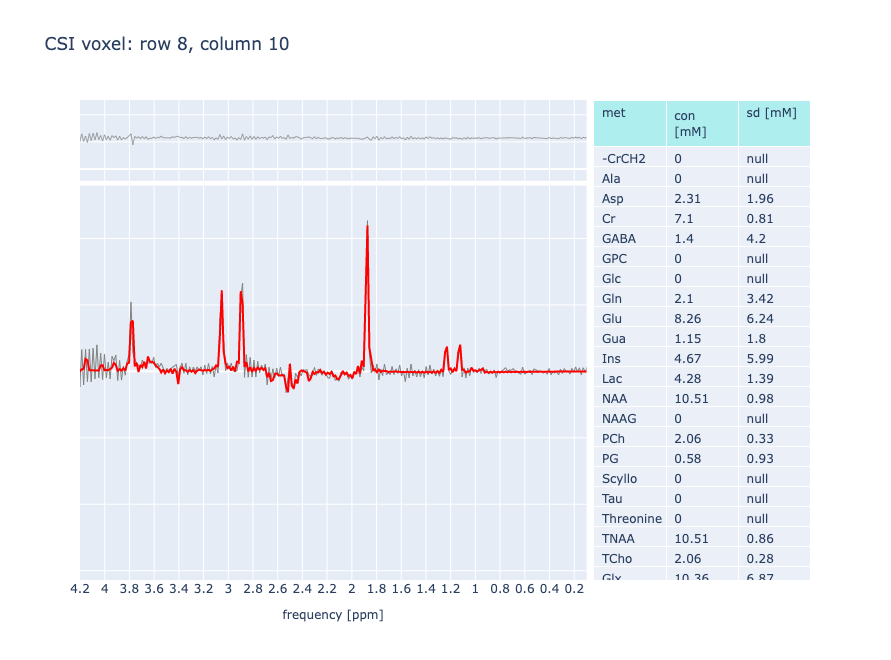

In [ ]:
vox_num = 20

df = pd.DataFrame(results_2d[vox_num][0]['metabolite_fits'])    
df = df.transpose()
df.reset_index(inplace=True)

df.sd = df.apply(lambda x: round(float(x.sd)*float(x.concentration)/100,2),axis=1)
df.concentration = df.apply(lambda x: round(float(x.concentration),2),axis=1)
df.columns =  ['met', 'con [mM]', 'sd [mM]']


fits = results_2d[vox_num][0]['plots']
data = fits['data']
fit = fits['fit']
baseline = fits['baseline']



# x0 = fit.frequency_axis_ppm()[0]
# x1 = fit.frequency_axis_ppm()[-1]
# ppm = np.linspace(x0,x1,data)
# 15.66711957443199

print(len(data))
ppm = np.linspace(15.66711957443199-3.15,-3.15,len(data))

d = {'ppm': ppm, 
     'data': data,
     'fit': fit,
     'baseline': baseline
    }

d['residue'] = d['data'] - d['fit'] - d['baseline'] + np.max(d['data'])*1
# df = pd.DataFrame(d)
# df.head()
# # # # pd.options.plotting.backend = "matplotlib"
# df.plot(x='ppm')
# plt.xlim([6,0])
# plt.legend()





s1 = 2
s2 = 2
fig = make_subplots(rows=s1, cols=s2,  shared_xaxes=True, shared_yaxes=True, 
                    vertical_spacing=0.01,
                    horizontal_spacing=0.01,
#                     column_widths=[0.6, 0.4],
                    row_heights=[0.17, 0.83],
   
                    column_widths=[0.7, 0.3],
                    specs=[
                           [{"type": "scatter"}, {"type": "table", "rowspan": 2}],
                           [{"type": "scatter"},   None            ]
                          ]
#                 specs=[[{}   , {}], 
#                        [{} , None]] 
            )

fig.add_trace(go.Scatter(x=ppm, y=np.real(d['data']-d['baseline']),name='data',opacity=1,line=dict(width=1, color='gray')),row=2,col=1)
# fig.add_trace(go.Scatter(x=ppm, y=np.real(d['baseline']),name='baseline',opacity=1,line=dict(width=1, color='mediumspringgreen')),row=2,col=1)
fig.add_trace(go.Scatter(x=ppm, y=np.real(d['fit']),name='fit',opacity=1, line=dict(width=2, color='red')),row=2,col=1)
fig.add_trace(go.Scatter(x=ppm, y=np.real(d['residue']),name='residue',opacity=1,line=dict(width=0.7, color='gray')),row=1,col=1)

fig.add_trace(go.Table(
                        header=dict(values=list(df.columns),
                                    fill_color='paleturquoise',
                                    align='left'),
    
                       cells=dict(
                                    values=[df[k].tolist() for k in df.columns],
                                    align = "left")
                        ),
              row=1,col=2)





fig.update_layout(
                    height=650, width=1000,
                  title_text=f"CSI voxel: row {results_2d[vox_num][1]['row']}, column {results_2d[vox_num][1]['col']}",
                legend=None,showlegend=False)
fig.update_yaxes(showticklabels=False)        
fig.update_xaxes(row=2,range=[4.2, 0.1], 
                 tickmode='linear',
                 dtick=0.2,
#                  tickangle = 40,
                 title_font = {"size": 12},
                 title_text='frequency [ppm]')
fig.update_xaxes(row=1,range=[4.2, 0.1], 
                 tickmode='linear',
                 dtick=0.2,
                )
#                  tickangle = 40,
#                  title_font = {"size": 12},
#                  title_text='frequency [ppm]')
#  fig.update_layout(
#             xaxis=dict(
#                 tickmode='linear',
#                 tick0=0.5,
#                 dtick=0.75
#             )
fig.show()






# fig2 = px.line(df.astype(np.float64), x = 'ppm', y = ['data','fit','baseline','residue'])
# fig2.update_layout(height=600, width=800,
#                   title_text="SV PRESS")
        
# fig2.update_xaxes(ticks='', range=[4, 0])
# fig2.show()

In [ ]:
fit.dt

0.0010000000474974513

In [ ]:
results_2d[vox_num][1]

{'csi_mat': [20, 24], 'row': 8, 'col': 10}

In [ ]:
series[0].sp_objects[0].SpectralWidth/series[0].sp_objects[200].Frequency

IndexError: list index out of range

In [ ]:
results_2d[44][0]

{'metabolite_fits': {'-CrCH2': {'concentration': '4.426', 'sd': '38.49'},
  'Ala': {'concentration': '0.4021', 'sd': '291.2'},
  'Asp': {'concentration': '0.000', 'sd': 'inf'},
  'Cr': {'concentration': '7.788', 'sd': '10.22'},
  'GABA': {'concentration': '0.000', 'sd': 'inf'},
  'GPC': {'concentration': '0.000', 'sd': 'inf'},
  'Glc': {'concentration': '0.000', 'sd': 'inf'},
  'Gln': {'concentration': '0.000', 'sd': 'inf'},
  'Glu': {'concentration': '3.649', 'sd': '100.3'},
  'Gua': {'concentration': '0.8199', 'sd': '215.9'},
  'Ins': {'concentration': '2.354', 'sd': '231.5'},
  'Lac': {'concentration': '4.570', 'sd': '32.20'},
  'NAA': {'concentration': '12.65', 'sd': '9.317'},
  'NAAG': {'concentration': '0.000', 'sd': 'inf'},
  'PCh': {'concentration': '2.303', 'sd': '20.42'},
  'PG': {'concentration': '0.3035', 'sd': '260.4'},
  'Scyllo': {'concentration': '0.2084', 'sd': '167.9'},
  'Tau': {'concentration': '0.000', 'sd': 'inf'},
  'Threonine': {'concentration': '0.8100', 'sd': 

### plot_CSI_voxel

In [ ]:
def plot_CSI_voxel(results_2d, vox_num=49, ID=''):

    df = pd.DataFrame(results_2d[vox_num][0]['metabolite_fits'])    
    df = df.transpose()
    df.reset_index(inplace=True)

    df.sd = df.apply(lambda x: round(float(x.sd)*float(x.concentration)/100,2),axis=1)
    df.concentration = df.apply(lambda x: round(float(x.concentration),2),axis=1)
    df.columns =  ['met', 'con [mM]', 'sd [mM]']

    fits = results_2d[vox_num][0]['plots']
    data = fits['data']
    fit = fits['fit']
    baseline = fits['baseline']

    SNR = results_2d[vox_num][0]['quality']['SNR residual'] 

    # x0 = fit.frequency_axis_ppm()[0]
    # x1 = fit.frequency_axis_ppm()[-1]
    # ppm = np.linspace(x0,x1,data)
    # 15.66711957443199

    ppm = np.linspace(15.66711957443199-3.15,-3.15,len(data))

    d = {'ppm': ppm, 
        'data': data,
        'fit': fit,
        'baseline': baseline
        }

    d['residue'] = d['data'] - d['fit'] - d['baseline'] + np.max(d['data'])*1
    # df = pd.DataFrame(d)
    # df.head()
    # # # # pd.options.plotting.backend = "matplotlib"
    # df.plot(x='ppm')
    # plt.xlim([6,0])
    # plt.legend()

    s1 = 2
    s2 = 2
    fig = make_subplots(rows=s1, cols=s2,  shared_xaxes=True, shared_yaxes=True, 
                        vertical_spacing=0.01,
                        horizontal_spacing=0.01,
    #                     column_widths=[0.6, 0.4],
                        row_heights=[0.17, 0.83],
    
                        column_widths=[0.7, 0.3],
                        specs=[
                            [{"type": "scatter"}, {"type": "table", "rowspan": 2}],
                            [{"type": "scatter"},   None            ]
                            ]
    #                 specs=[[{}   , {}], 
    #                        [{} , None]] 
                )

    fig.add_trace(go.Scatter(x=ppm, y=np.real(d['data']-d['baseline']),name='data',opacity=1,line=dict(width=1, color='gray')),row=2,col=1)
    # fig.add_trace(go.Scatter(x=ppm, y=np.real(d['baseline']),name='baseline',opacity=1,line=dict(width=1, color='mediumspringgreen')),row=2,col=1)
    fig.add_trace(go.Scatter(x=ppm, y=np.real(d['fit']),name='fit',opacity=1, line=dict(width=2, color='red')),row=2,col=1)
    fig.add_trace(go.Scatter(x=ppm, y=np.real(d['residue']),name='residue',opacity=1,line=dict(width=0.7, color='gray')),row=1,col=1)

    fig.add_trace(go.Table(
                            header=dict(values=list(df.columns),
                                        fill_color='paleturquoise',
                                        align='left'),
        
                        cells=dict(
                                        values=[df[k].tolist() for k in df.columns],
                                        align = "left")
                            ),
                row=1,col=2)





    fig.update_layout(
                    height=650, width=1000,
                    title_text=f"    {ID}   CSI voxel: row {results_2d[vox_num][1]['row']}, column {results_2d[vox_num][1]['col']}.   SNR={SNR}",
                    legend=None,showlegend=False)
    
    fig.update_yaxes(showticklabels=False)        
    fig.update_xaxes(row=2,range=[4.2, 0.1], 
                    tickmode='linear',
                    dtick=0.2,
    #                  tickangle = 40,
                    title_font = {"size": 12},
                    title_text='frequency [ppm]')
    fig.update_xaxes(row=1,range=[4.2, 0.1], 
                    tickmode='linear',
                    dtick=0.2,
                    )
    #                  tickangle = 40,
    #                  title_font = {"size": 12},
    #                  title_text='frequency [ppm]')
    #  fig.update_layout(
    #             xaxis=dict(
    #                 tickmode='linear',
    #                 tick0=0.5,
    #                 dtick=0.75
    #             )
#     fig.show()
    fig.write_image(f'csi_fit_{ID}.png')







    # fig2 = px.line(df.astype(np.float64), x = 'ppm', y = ['data','fit','baseline','residue'])
    # fig2.update_layout(height=600, width=800,
    #                   title_text="SV PRESS")
            
    # fig2.update_xaxes(ticks='', range=[4, 0])
    # fig2.show()

### QC

In [ ]:

Q = result[][0]['quality']['Q']
SNR = result[5][0]['quality']['SNR residual']   

print(f'{Q = }\n{SNR = }')


NameError: name 'result' is not defined

TypeError: 'float' object is not iterable

(*args) = 1
(*args) = 2



A = 1
B = 2



# Do it all using the saved fits.

In [ ]:
# main_folder = Path('/Users/papo/Sync/MRdata/Uganda/All_data/EK/')
main_folder = Path('/Users/papo/Sync/MRdata/Uganda/SpectroscopyPhantomData/SPECTROSCOPY PHATOM SCAN_scan2')

data_folders = (item for item in main_folder.glob('*') if item.is_dir())
data_folders =(item for item in data_folders if 'dicom' not in str(item).lower())


study_tags = {i:data_folder.stem[0:data_folder.stem.find('_')] for i,data_folder in enumerate(data_folders)}
# pprint(study_tags)

results_folder = Path('/Users/papo/Sync/MRdata/Uganda/SpectroscopyPhantomData/SPECTROSCOPY PHATOM SCAN_scan2')
result_files = results_folder.glob('results_2d_*.pickle')
try:
    result_codes = {study_tags[int(result.stem[-2::])]:result for result in result_files}
except:
    result_codes = {study_tags[int(result.stem[-1::])]:result for result in result_files}
    
# pprint(result_codes)

plt.close('all')
for code,file in result_codes.items():
    with open(file, 'rb') as f:
        result = pickle.load(f)
        SNR = [voxel[0]['quality']['SNR residual'] for voxel in result]
        
    best_voxel= SNR.index(np.max(SNR[20:80]))
    median= sorted(SNR)[int(np.round(len(SNR)/2))]
    median_voxel= SNR.index(median)

    print(f'{best_voxel=}')
    print(f'{median_voxel=}')
    
    csi_ref_2(result,code,best_voxel,median_voxel);

#     met_ratio_maps(result,code) 
#     met_ratio_maps_v2(result,code, snr_mask=3)  
    met_ratio_maps_v2(result,code, snr_mask=6)  
#     met_ratio_maps_v2(result,code, snr_mask=9)  

    plot_CSI_voxel(result,best_voxel,f'{code} max SNR')
    plot_CSI_voxel(result,median_voxel,f'{code} median SNR')



#     SNR = np.array(SNR)
#     SNR[SNR<6] = 100
#     v8 = np.argmin(SNR)
#     print(f'{v8=}')
#     if v8<6:
#         plot_CSI_voxel(result,best_voxel,f'{code} CANNOT MEET THRESHOLD QUALITY')
#         csi_ref_2(result,code,best_voxel);
    
#     else:
#         plot_CSI_voxel(result,v8,f'{code} Threshold Quality Spectrum')
#         csi_ref_2(result,code,best_voxel,v8);


    print_report_2D_PRESS_3(result,code)

    
#     plt.close('all')




In [ ]:

def print_report_2D_PRESS_2(results_2d,ID=''):
    UCLH_header = str(Path.cwd()/'Icons/UCLH_header.png')
    UCLH_footer = str(Path.cwd()/'Icons/UCLH_footer.png')
    
    
#     exported_folder = press_data.filename.parent.parent
#     if exported_folder.stem.lower() == 'dicom':
#         exported_folder = exported_folder.parent  
    if ID == '':    
        exported_folder = Path(folder)
        ID = exported_folder.stem
        if ID.find('_MRS') != -1:
            ID = ID[0:ID.find('_MRS')]
        
  
    
    class PDF(FPDF):

        def header(self):
            # Logo
            self.image(UCLH_header, 120, 12, 80)
            # Arial bold 15
            self.set_font('Arial', '', 10)
            # Move to the right
            self.cell(10)
            # Title
            self.cell(0, 10, 'Section: MRI', 0, 1, 'L')
            self.cell(10)
            self.cell(0,0, 'Medical Physics and Biomedical Engineering', 0,0,'L')
            self.line(20,25,200,25)
            # Line break
            self.ln(15)

        # Page footer
        def footer(self):
            # Logo
            self.image(UCLH_footer, 20, 270, 160)
            #self.image('S:\\Alan_projects\\Logos_do_not_alter\\UCLH_Footer.png', 20, 270, 160)
            # Position at 1.5 cm from bottom
            self.set_y(-40)
            # Arial italic 8
            self.set_font('Arial', 'I', 10)
            # Footer
            self.cell(10)
            self.cell(45, 10, 'Brain MRS Report', 1, 0, 'C')
            #self.cell(90)
            self.cell(45, 10, 'Tarquin Version 4.3.11', 1, 0, 'C')
            i = datetime.datetime.now()
            datetext = 'Date: ' +str(i.day) + '/' + str(i.month) + '/' + str(i.year)
            self.cell(45,10, datetext, 1,0,'C')
            self.cell(45,10, 'Page 1 of 2', 1,0,'C')
    pdf = PDF()
    pdf.alias_nb_pages()
    pdf.add_page()
    pdf.set_font('Arial', 'B', 16)
    titleout = f'Patient ID {ID}: Chemical Shift Imaging results' 
    pdf.cell(10)
    pdf.cell(0,0, titleout, 0,0,'L')
    pdf.ln(15)

    pdf.set_font('Arial', 'B', 12)
    pdf.cell(10)
    pdf.cell(0,0, 'Structural refence, max-SNR and median-SNR spectra:', 0,0,'L')
    pdf.cell(5)
    
    
    pdf.ln(5)

    x0=pdf.get_x()
    y0=pdf.get_y()
    pdf.image(f'/Users/papo/Sync/Projects/Uganda_MRS/csi_int_{ID}.png',                              w = 70, h = 60, type = '', link = '')
    pdf.image(f'/Users/papo/Sync/Projects/Uganda_MRS/csi_fit_{ID} max SNR.png',    x = x0+60, y = y0, w = 70, h = 60, type = '', link = '')
    pdf.image(f'/Users/papo/Sync/Projects/Uganda_MRS/csi_fit_{ID} median SNR.png', x = x0+125, y = y0, w = 70, h = 60, type = '', link = '')

    pdf.set_font('Arial','I', 10)
    pdf.ln(2)
    pdf.cell(0,0, '          Spectra of the highlighted voxels shown:', 0,0,'L')
    pdf.ln(4)

    pdf.cell(0,0, '          Highest SNR spectrum in the miidle (yellow voxel). Median SNR spectrum on the right (orange voxel).', 0,0,'L')
    
    pdf.cell(5)
    
    
    pdf.ln(15)
    pdf.set_font('Arial', 'B', 14)
    pdf.cell(10)
    pdf.cell(-10,0, 'Metabolite concentration [mM] and Metabolite Ratio maps:', 0,0,'L')
    pdf.cell(5)
    pdf.ln(5)

    pdf.image(f'/Users/papo/Sync/Projects/Uganda_MRS/csi_map_{ID}.png', x = 20, y = None, w = 150, h = 100, type = '', link = '')
    
    pdf.output(f'2D_PRESS_Report_{ID}.pdf', 'F')
    print(' - Report ready.')   
    
    
    
def csi_ref_2(results_2d,ID='',max_voxel=None, median_voxel=None):
        
    csi_size = results_2d[0][1]['csi_mat']
    mymat = np.zeros(csi_size)
    for voxel in results_2d:
#         ref = voxel[0]['plots']['data']
        ref = voxel[0]['plots']['fit']
        metric = np.sum(np.abs(ref.flatten()))
        row = voxel[1]['row']  
        col = voxel[1]['col']
        mymat[row,col] = metric  

    mymat = 0.3*mymat/np.max(mymat)
#     mymat[mymat<0.01] = np.nan
    if max_voxel:
        row = results_2d[max_voxel][1]['row']
        col = results_2d[max_voxel][1]['col']
        mymat[row,col] = 1
        
    if median_voxel:
        row = results_2d[median_voxel][1]['row']
        col = results_2d[median_voxel][1]['col']
        mymat[row,col] = 0.75

    plt.figure()    
    c = plt.imshow(mymat, cmap ='gnuplot2_r', interpolation ='nearest', origin ='lower') 
#     plt.colorbar(c) 
    plt.title('CSI structure',fontweight ="bold") 
    plt.axis('off')
#             plt.show() 
    plt.savefig(f'csi_int_{ID}.png')

    return mymat    
    

In [ ]:
pprint(result[best_voxel][0]['plots']['fit'])

MRSSpectrum([0.0848428+0.j, 0.0831218+0.j, 0.0848566+0.j, ...,
             0.0828878+0.j, 0.0848298+0.j, 0.0830005+0.j])


In [ ]:
col


NameError: name 'col' is not defined

In [ ]:
voxel[0]['plots']['metabolites']['NAA']


MRSSpectrum([-0.00804444+0.j, -0.013666  +0.j, -0.00804153+0.j, ...,
             -0.0140253 +0.j, -0.00804737+0.j, -0.013858  +0.j])

In [ ]:
def print_report_2D_PRESS_3(results_2d,ID=''):
    UCLH_header = str(Path.cwd()/'Icons/UCLH_header.png')
    UCLH_footer = str(Path.cwd()/'Icons/UCLH_footer.png')
    
    
#     exported_folder = press_data.filename.parent.parent
#     if exported_folder.stem.lower() == 'dicom':
#         exported_folder = exported_folder.parent  
    if ID == '':    
        exported_folder = Path(folder)
        ID = exported_folder.stem
        if ID.find('_MRS') != -1:
            ID = ID[0:ID.find('_MRS')]
        
  
    
    class PDF(FPDF):

        def header(self):
            # Logo
            self.image(UCLH_header, 120, 12, 80)
            # Arial bold 15
            self.set_font('Arial', '', 10)
            # Move to the right
            self.cell(10)
            # Title
            self.cell(0, 10, 'Section: MRI', 0, 1, 'L')
            self.cell(10)
            self.cell(0,0, 'Medical Physics and Biomedical Engineering', 0,0,'L')
            self.line(20,25,200,25)
            # Line break
            self.ln(15)

        # Page footer
        def footer(self):
            # Logo
            self.image(UCLH_footer, 20, 270, 160)
            #self.image('S:\\Alan_projects\\Logos_do_not_alter\\UCLH_Footer.png', 20, 270, 160)
            # Position at 1.5 cm from bottom
            self.set_y(-40)
            # Arial italic 8
            self.set_font('Arial', 'I', 10)
            # Footer
            self.cell(10)
            self.cell(45, 10, 'Brain MRS Report', 1, 0, 'C')
            #self.cell(90)
            self.cell(45, 10, 'Tarquin Version 4.3.11', 1, 0, 'C')
            i = datetime.datetime.now()
            datetext = 'Date: ' +str(i.day) + '/' + str(i.month) + '/' + str(i.year)
            self.cell(45,10, datetext, 1,0,'C')
            self.cell(45,10, 'Page 1 of 2', 1,0,'C')
    pdf = PDF()
    pdf.alias_nb_pages()
    pdf.add_page()
    pdf.set_font('Arial', 'B', 16)
    titleout = f'Patient ID {ID}: Chemical Shift Imaging results' 
    pdf.cell(10)
    pdf.cell(0,0, titleout, 0,0,'L')
    pdf.ln(15)

    pdf.set_font('Arial', 'B', 12)
    pdf.cell(10)
    pdf.cell(0,0, 'Refence image, max-SNR and lower-bound-SNR spectra:', 0,0,'L')
    pdf.cell(5)
    
    
    pdf.ln(5)

    x0=pdf.get_x()
    y0=pdf.get_y()
    pdf.image(f'/Users/papo/Sync/Projects/Uganda_MRS/csi_int_{ID}.png',       x = x0-10,   w = 70, h = 60, type = '', link = '')
    
    pdf.image(f'/Users/papo/Sync/Projects/Uganda_MRS/csi_fit_{ID} max SNR.png',    x = x0+60-15, y = y0, w = 70, h = 60, type = '', link = '')
    if Path(f'/Users/papo/Sync/Projects/Uganda_MRS/csi_fit_{ID} Threshold Quality Spectrum.png').is_file():
        above_threshold = True
    else:
        above_threshold = False
        
    if above_threshold:
        pdf.image(f'/Users/papo/Sync/Projects/Uganda_MRS/csi_fit_{ID} Threshold Quality Spectrum.png', x = x0+125-15, y = y0, w = 70, h = 60, type = '', link = '')
#     else:
#         pdf.image(f'/Users/papo/Sync/Projects/Uganda_MRS/csi_fit_{ID} CANNOT MEET THRESHOLD QUALITY.png', x = x0+125, y = y0, w = 70, h = 60, type = '', link = '')
        
    pdf.set_font('Arial','I', 10)
    pdf.ln(2)

    if above_threshold:
        pdf.cell(0,0, '           Spectra of the highlighted voxels:', 0,0,'L')
        pdf.ln(4)
        pdf.cell(0,0, '           Left spectrum: Highest SNR (voxel in black).  Right spectrum: Lowest SNR (voxel in blue).', 0,0,'L')
    else:
        pdf.cell(0,0, '           Spectrum of the highest SNR voxel (highlighted in black).', 0,0,'L')
        pdf.ln(4)
        pdf.cell(0,0, '           THE SNR IS BELOW THE ACCEPTABLE CUTOFF VALUE OF 6.', 0,0,'L')

        
    pdf.cell(5)
    
    
    pdf.ln(15)
    pdf.set_font('Arial', 'B', 12)
    pdf.cell(10)
    pdf.cell(-10,0, 'Metabolite concentration [mM] and Metabolite Ratio maps:', 0,0,'L')
    pdf.cell(5)
    pdf.ln(5)

    pdf.image(f'/Users/papo/Sync/Projects/Uganda_MRS/csi_map_{ID}_SNRmask6.png', x = 20, y = None, w = 150, h = 100, type = '', link = '')
    pdf.set_font('Arial','I', 10)
    pdf.ln(3)
    pdf.cell(0,0, '              The maps have been masked with a threshold of SNR > 6 to avoid very low quality fits.', 0,0,'L')
    
    pdf.output(f'2D_PRESS_Report_{ID}.pdf', 'F')
    print(' - Report ready.')   
    

In [ ]:

met_ratio_maps_v2(result, ID='test',snr_mask=5)

<ipython-input-22-2124e7edafb4>:804: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<ipython-input-22-2124e7edafb4>:805: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<ipython-input-22-2124e7edafb4>:806: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# testing code

In [ ]:
get_met_info(['Lac'], results_2d[0])

<ipython-input-2-2124e7edafb4>:264: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  con = np.float(results['metabolite_fits'][met]['concentration'])


{'Lac': {'concentration': 0.0, 'sd': 0}}

In [ ]:
results_2d[0]

[{'metabolite_fits': {'-CrCH2': {'concentration': '0.000', 'sd': 'inf'},
   'Ala': {'concentration': '0.000', 'sd': 'inf'},
   'Asp': {'concentration': '2.665', 'sd': '81.13'},
   'Cr': {'concentration': '2.620', 'sd': '32.00'},
   'GABA': {'concentration': '3.083', 'sd': '154.0'},
   'GPC': {'concentration': '0.000', 'sd': 'inf'},
   'Glc': {'concentration': '12.30', 'sd': '103.4'},
   'Gln': {'concentration': '0.000', 'sd': 'inf'},
   'Glu': {'concentration': '0.000', 'sd': 'inf'},
   'Gua': {'concentration': '2.099', 'sd': '117.7'},
   'Ins': {'concentration': '5.987', 'sd': '161.3'},
   'Lac': {'concentration': '2.108', 'sd': '102.5'},
   'NAA': {'concentration': '2.552', 'sd': '35.52'},
   'NAAG': {'concentration': '0.000', 'sd': 'inf'},
   'PCh': {'concentration': '0.7936', 'sd': '44.43'},
   'PG': {'concentration': '1.262', 'sd': '79.78'},
   'Scyllo': {'concentration': '0.4753', 'sd': '117.2'},
   'Tau': {'concentration': '2.570', 'sd': '144.0'},
   'Threonine': {'concentration

In [ ]:
result_codes = {'scan2': Path('/Users/papo/Sync/MRdata/Uganda/SpectroscopyPhantomData/SPECTROSCOPY PHATOM SCAN_scan2/results_2d_1.pickle')}

plt.close('all')
for code,file in result_codes.items():
    with open(file, 'rb') as f:
        result = pickle.load(f)
        SNR = [voxel[0]['quality']['SNR residual'] for voxel in result]
        
    best_voxel= SNR.index(np.max(SNR[20:80]))
    median= sorted(SNR)[int(np.round(len(SNR)/2))]
    median_voxel= SNR.index(median)

    print(f'{best_voxel=}')
    print(f'{median_voxel=}')
    
    csi_ref_2(result,code,best_voxel,median_voxel);

#     met_ratio_maps(result,code) 
#     met_ratio_maps_v2(result,code, snr_mask=3)  
    met_ratio_maps_v2(result,code, snr_mask=6)
#     met_ratio_maps_v2(result,code, snr_mask=9)  

    plot_CSI_voxel(result,best_voxel,f'{code} max SNR')
    plot_CSI_voxel(result,median_voxel,f'{code} median SNR')



    SNR = np.array(SNR)
    SNR[SNR<6] = 100
    v8 = np.argmin(SNR)
    print(f'{v8=}')
    if v8<6:
        plot_CSI_voxel(result,best_voxel,f'{code} CANNOT MEET THRESHOLD QUALITY')
        csi_ref_2(result,code,best_voxel);
    
    else:
        plot_CSI_voxel(result,v8,f'{code} Threshold Quality Spectrum')
        csi_ref_2(result,code,best_voxel,v8);


    print_report_2D_PRESS_3(result,code)


best_voxel=26
median_voxel=13


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-161-2124e7edafb4>:804: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<ipython-input-161-2124e7edafb4>:805: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<ipython-input-161-2124e7edafb4>:806: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing t

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

v8=0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

 - Report ready.


SyntaxError: invalid syntax (<ipython-input-146-83b3d06d700f>, line 6)